### Описание набора данных
Набор данных о зарплатах в Data Science содержит 11 колонок, каждая из которых:

- **work_year**: Год, в котором была выплачена зарплата.
- **experience_level**: Уровень опыта на работе в течение данного года.
- **employment_type**: Тип занятости для данной роли.
- **job_title**: Название должности, на которой работали в течение года.
- **salary**: Общая сумма выплаченной брутто-зарплаты.
- **salary_currency**: Валюта, в которой выплачивалась зарплата, в формате ISO 4217.
- **salary_in_usd**: Зарплата, переведённая в доллары США.
- **employee_residence**: Основная страна проживания сотрудника в течение рабочего года в формате ISO 3166.
- **remote_ratio**: Общая доля работы, выполненной удалённо.
- **company_location**: Страна, где находится главный офис работодателя или его филиал.
- **company_size**: Среднее количество сотрудников, работавших в компании в течение года.

### Зарплаты в Data Science 2023: Великая дата-экспедиция и комедийное шоу!

Добро пожаловать, отважный исследователь данных, на самое эпическое путешествие по набору данных о зарплатах в Data Science за 2023 год! Сегодня мы не просто будем анализировать, визуализировать и моделировать наши данные — мы будем делать это с удовольствием и улыбкой!

#### Что нас ждёт?

- **Исследование данных:** Мы будем охотиться на пропущенные значения, находить скрытые сокровища и смеяться над забавными аномалиями.  
- **Глубокий EDA (Exploratory Data Analysis):** С красочными графиками и интерактивными визуализациями мы узнаем, что определяет размер зарплат.  
- **Создание признаков:** Преобразуем сырые данные в настоящее золото.  
- **Предиктивное моделирование:** Наш чемпион — регрессор XGBoost (отточенный до совершенства) — поможет нам предсказать эти зарплаты.  
- **Рассказывание историй и GIF-ки:** Наслаждайтесь парадом забавных GIF-ов от Giphy, которые поднимут вам настроение!

Давайте начнём! И помните: в мире данных даже самые причудливые цифры могут вызвать улыбку! 😊

# 1. Импорт библиотек с ноткой юмора

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score

from xgboost import XGBRFRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from category_encoders import OneHotEncoder, TargetEncoder, BinaryEncoder
from mlxtend.plotting import plot_decision_regions

# 2. Загрузка набора данных
Прежде чем погрузиться в анализ, убедитесь, что вы скачали набор данных с Kaggle и поместили его в вашу рабочую директорию под именем **`data_science_salaries_2023.csv`**.

Давайте загрузим наш **сундук с сокровищами данных** — надеемся, что никаких "гоблинов пропавших файлов" на пути не будет! 🗃️💎

In [2]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

sns.set(style="whitegrid", palette="muted")

warnings.filterwarnings("ignore")

df1 = pd.read_csv("datasets/ds_salaries.csv")
df2 = pd.read_csv("datasets/salaries.csv")
df3 = pd.read_csv("datasets/ds_salary_2024.csv")
df4 = pd.read_csv("datasets/global_ai_ml_data_salaries.csv")


print("Размер 1-го датасета: ", df1.shape)
print("Размер 2-го датасета: ", df2.shape)
print("Размер 3-го датасета: ", df3.shape)
print("Размер 4-го датасета: ", df4.shape)

Размер 1-го датасета:  (3755, 11)
Размер 2-го датасета:  (13730, 11)
Размер 3-го датасета:  (16534, 11)
Размер 4-го датасета:  (40332, 11)


In [3]:
print("Первый датасет:")
display(df1.head(5))

print("Второй датасет:")
display(df2.head(5))

print("Третый датасет:")
display(df3.head(5))

print("Четвертый датасет:")
display(df4.head(5))

Первый датасет:


,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M


Второй датасет:


,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2024,MI,FT,AI Architect,800000,USD,800000,CA,100,CA,M
1,2023,EN,FT,Data DevOps Engineer,44382,EUR,47918,NL,50,NL,L
2,2024,EN,FT,Data Analyst,40100,EUR,44555,LT,0,LT,M
3,2024,EN,FT,Data Analyst,28069,EUR,31187,LT,0,LT,M
4,2024,SE,FT,Data Engineer,220000,USD,220000,US,0,US,M


Третый датасет:


,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2024,SE,FT,AI Engineer,202730,USD,202730,US,0,US,M
1,2024,SE,FT,AI Engineer,92118,USD,92118,US,0,US,M
2,2024,SE,FT,Data Engineer,130500,USD,130500,US,0,US,M
3,2024,SE,FT,Data Engineer,96000,USD,96000,US,0,US,M
4,2024,SE,FT,Machine Learning Engineer,190000,USD,190000,US,0,US,M


Четвертый датасет:


,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2024,SE,FT,Data Architect,170955,USD,170955,US,0,US,M
1,2024,SE,FT,Data Architect,130270,USD,130270,US,0,US,M
2,2024,MI,FT,Insight Analyst,92144,USD,92144,US,100,US,M
3,2024,MI,FT,Insight Analyst,57616,USD,57616,US,100,US,M
4,2024,SE,FT,Lead Engineer,201600,USD,201600,US,100,US,M


In [4]:
# Объединение по строкам
# df = pd.concat([df1, df2, df3, df4], axis=0, ignore_index=True).drop_duplicates()
df = pd.concat([df1, df2, df3], axis=0, ignore_index=True).drop_duplicates()
# df = pd.concat([df4, df3], axis=0, ignore_index=True).drop_duplicates()

# Проверка размера нового датасета
print(f"Размер датасета после объеденения и удаления дубликатов: {df.shape}")

# Проверим результат
display(df.head())

Размер датасета после объеденения и удаления дубликатов: (10287, 11)


,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M


# 3. Исследование и очистка данных

1. **Пропущенные значения:** Есть ли коварные пробелы в наших данных?  
2. **Типы данных:** Все ли колонки "одеты" правильно для этого квеста?  
3. **Описательная статистика:** Цифры тоже могут быть забавными!  
4. **Количество уникальных:** Сколько королей и королев Data Science обитает в нашем королевстве?
5. **Дубликаты:** Мы любим уникальные сокровища — проверим, нет ли повторов.  

In [5]:
print("Пропущенные значения в столбцах:")
df.isna().sum()

Пропущенные значения в столбцах:


work_year             0
experience_level      0
employment_type       0
job_title             0
salary                0
salary_currency       0
salary_in_usd         0
employee_residence    0
remote_ratio          0
company_location      0
company_size          0
dtype: int64

In [6]:
print("Типы данных:")
df.dtypes.sort_values()

Типы данных:


work_year              int64
salary                 int64
salary_in_usd          int64
remote_ratio           int64
experience_level      object
employment_type       object
job_title             object
salary_currency       object
employee_residence    object
company_location      object
company_size          object
dtype: object

In [7]:
print("Описательные статистики:")
df.describe().round(2)

Описательные статистики:


,work_year,salary,salary_in_usd,remote_ratio
count,10287.00,10287.00,10287.00,10287.00
mean,2023.22,170836.71,145168.71,35.80
std,0.79,433629.56,73302.93,47.25
min,2020.00,6000.00,5132.00,0.00
25%,2023.00,95000.00,93869.00,0.00
50%,2023.00,139200.00,137141.00,0.00
75%,2024.00,187635.00,185000.00,100.00
max,2024.00,30400000.00,800000.00,100.00


In [8]:
print("Количество уникальных значений в каждом столбце: ")
df.nunique()

Количество уникальных значений в каждом столбце: 


work_year                5
experience_level         4
employment_type          4
job_title              157
salary                2577
salary_currency         24
salary_in_usd         3052
employee_residence      91
remote_ratio             3
company_location        83
company_size             3
dtype: int64

In [9]:
dublicated = df.duplicated().sum()
print(f"Количество дубликатов: {dublicated}")

Количество дубликатов: 0


--------
# 4. Исследовательский анализ данных (EDA) – Сердце нашего приключения
Время для ярких и интерактивных визуализаций! Мы собираемся:

1. **Раскрыть распределение зарплат:** Узнаем, как распределены зарплаты в долларах США.  
2. **Опыт vs. Зарплата:** Всегда ли больше опыта означает больше "золота"?  
3. **Частота должностей:** Какие роли правят королевством?  
4. **Магия удалённой работы:** Как удалённая работа влияет на "сундук с сокровищами"?  
5. **Географические сражения:** Кто и где работает?  
6. **Тепловая карта корреляции:** Обнаружим тайные связи между признаками.  

**Берите попкорн — вот где начинается настоящее веселье! 🍿📊**

## Распределение заработной платы в долларах США

Смещение ЗП от среднего: 1.59


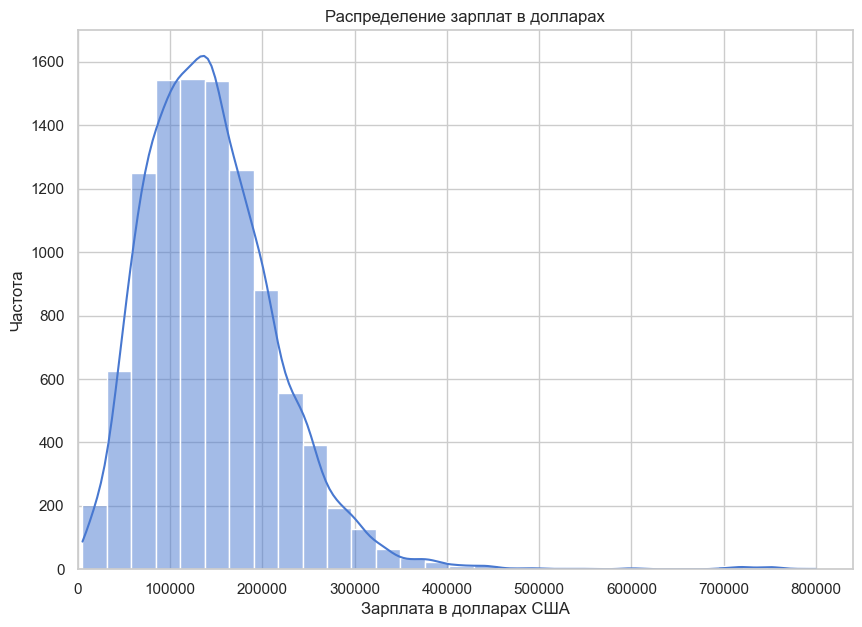

In [10]:
skewness = df['salary_in_usd'].skew()
print(f"Смещение ЗП от среднего: {skewness:.2f}")

plt.figure(figsize=(10, 7))
sns.histplot(df, x="salary_in_usd", kde=True, bins=30)
plt.title("Распределение зарплат в долларах")
plt.xlabel("Зарплата в долларах США")
plt.ylabel("Частота")
plt.xlim(0)
plt.show()

## Зарплата по уровню опыта (Boxplot)

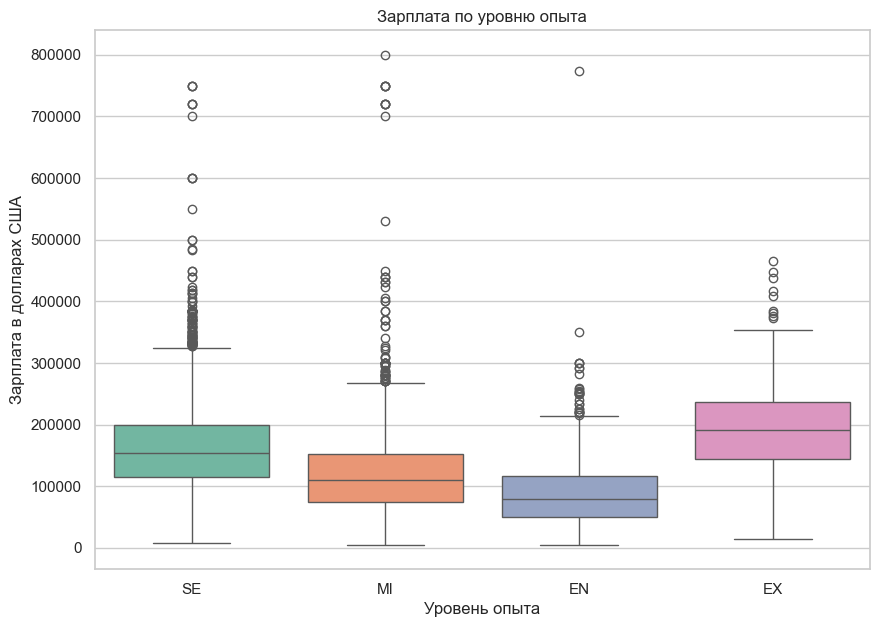

In [11]:
plt.figure(figsize=(10, 7))
sns.boxplot(df, x="experience_level", y="salary_in_usd", palette="Set2")
plt.title("Зарплата по уровню опыта")
plt.xlabel("Уровень опыта")
plt.ylabel("Зарплата в долларах США")
plt.show()

**Уровень опыта сотрудников:**  

- **SE (Senior)** – **Старший специалист**: Опытный профессионал с глубокими знаниями в своей области, способный брать на себя сложные задачи и руководить проектами.  
- **MI (Mid-Level)** – **Средний уровень**: Специалист с достаточным опытом, способный работать автономно, но всё же не на уровне эксперта.  
- **EN (Entry-Level)** – **Начальный уровень (Junior)**: Специалист на старте карьеры, обычно с ограниченным опытом, но готовый обучаться.  
- **EX (Executive/Director)** – **Руководитель/Директор**: Человек на руководящей должности, отвечающий за стратегические решения и управление командой.  

## Частота названий должностей (Countplot)

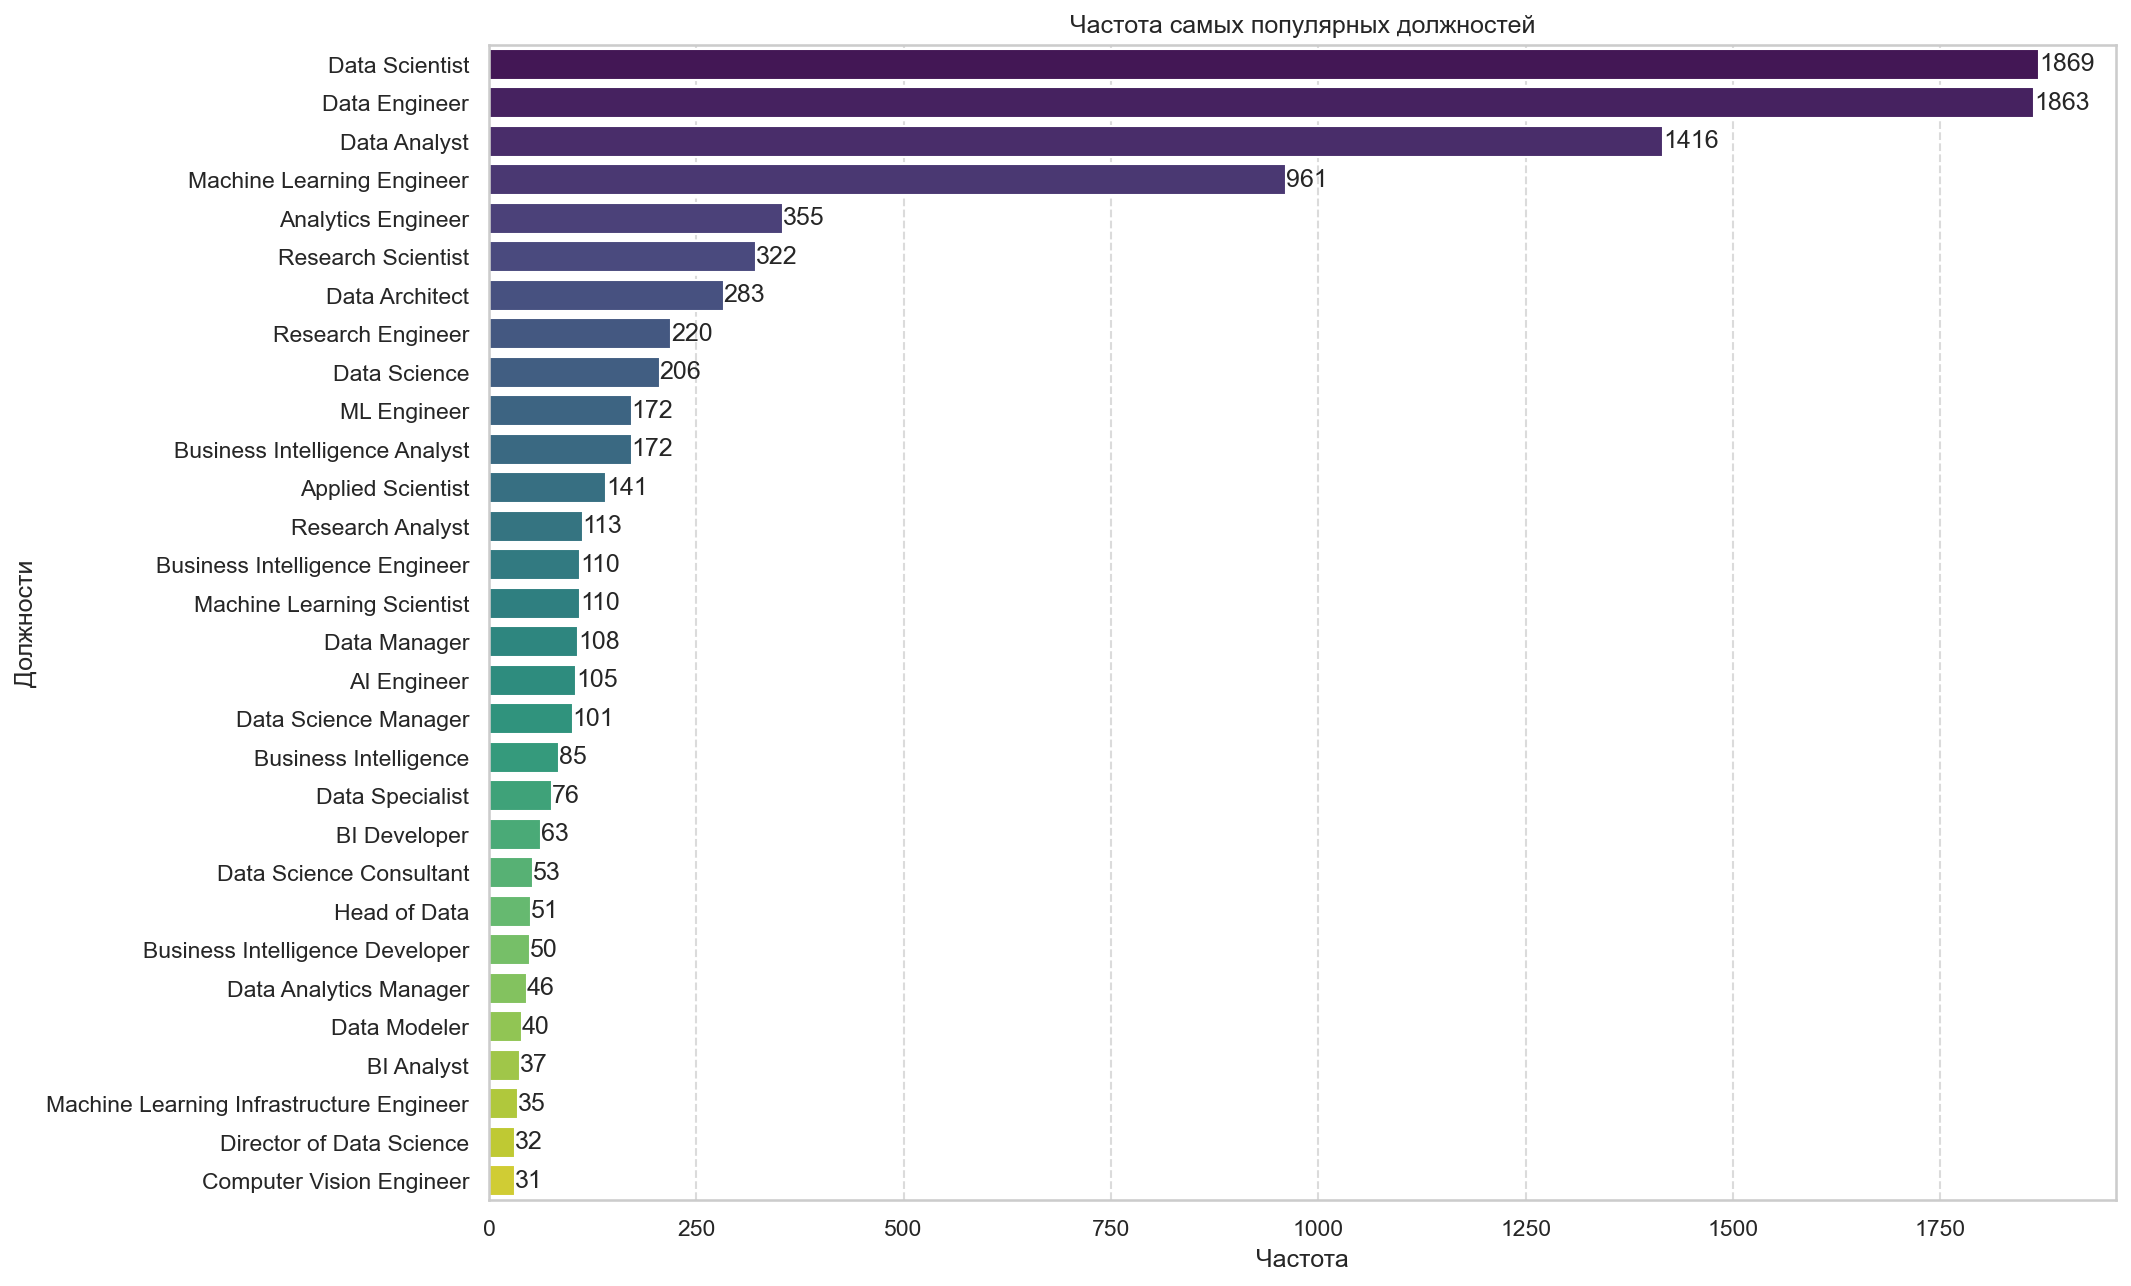

In [12]:
plt.figure(figsize=(14, 10), dpi=150)

top_job_titles = df["job_title"].value_counts().nlargest(30)

sns.barplot(y=top_job_titles.index, x=top_job_titles.values, palette="viridis")
plt.title("Частота самых популярных должностей")
plt.xlabel("Частота")
plt.ylabel("Должности")

for index, value in enumerate(top_job_titles):
    plt.text(value, index, str(value), va="center")
    
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()

## Коэффициент удаленной работы vs зарплата (Scatterplot)

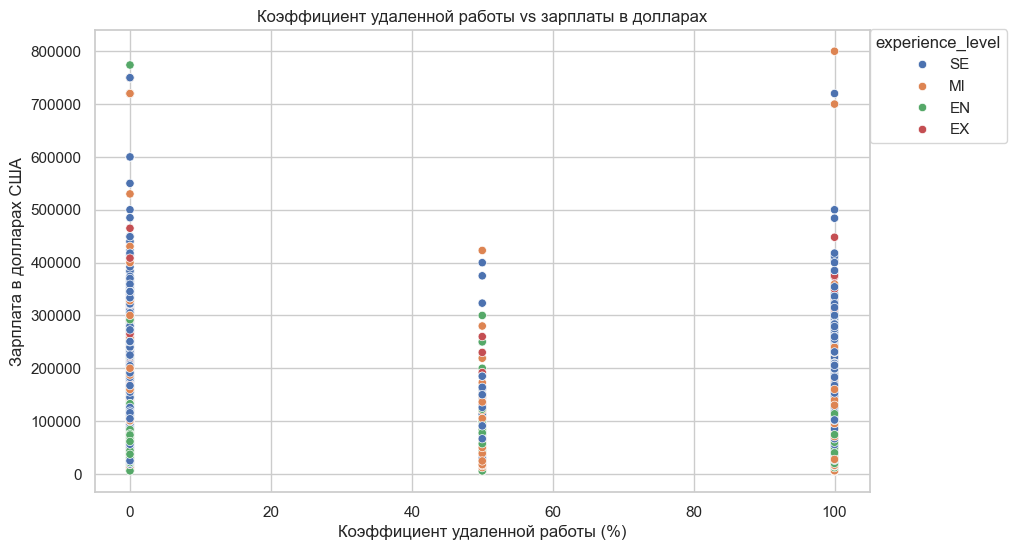

In [13]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="remote_ratio", y="salary_in_usd", 
                hue="experience_level", palette="deep")
plt.xlabel("Коэффициент удаленной работы (%)")
plt.ylabel("Зарплата в долларах США")
plt.title("Коэффициент удаленной работы vs зарплаты в долларах")
plt.legend(title="experience_level", loc=(1, 0.755))
plt.show()

## Средняя зарплата по должностям (Bar Plot)

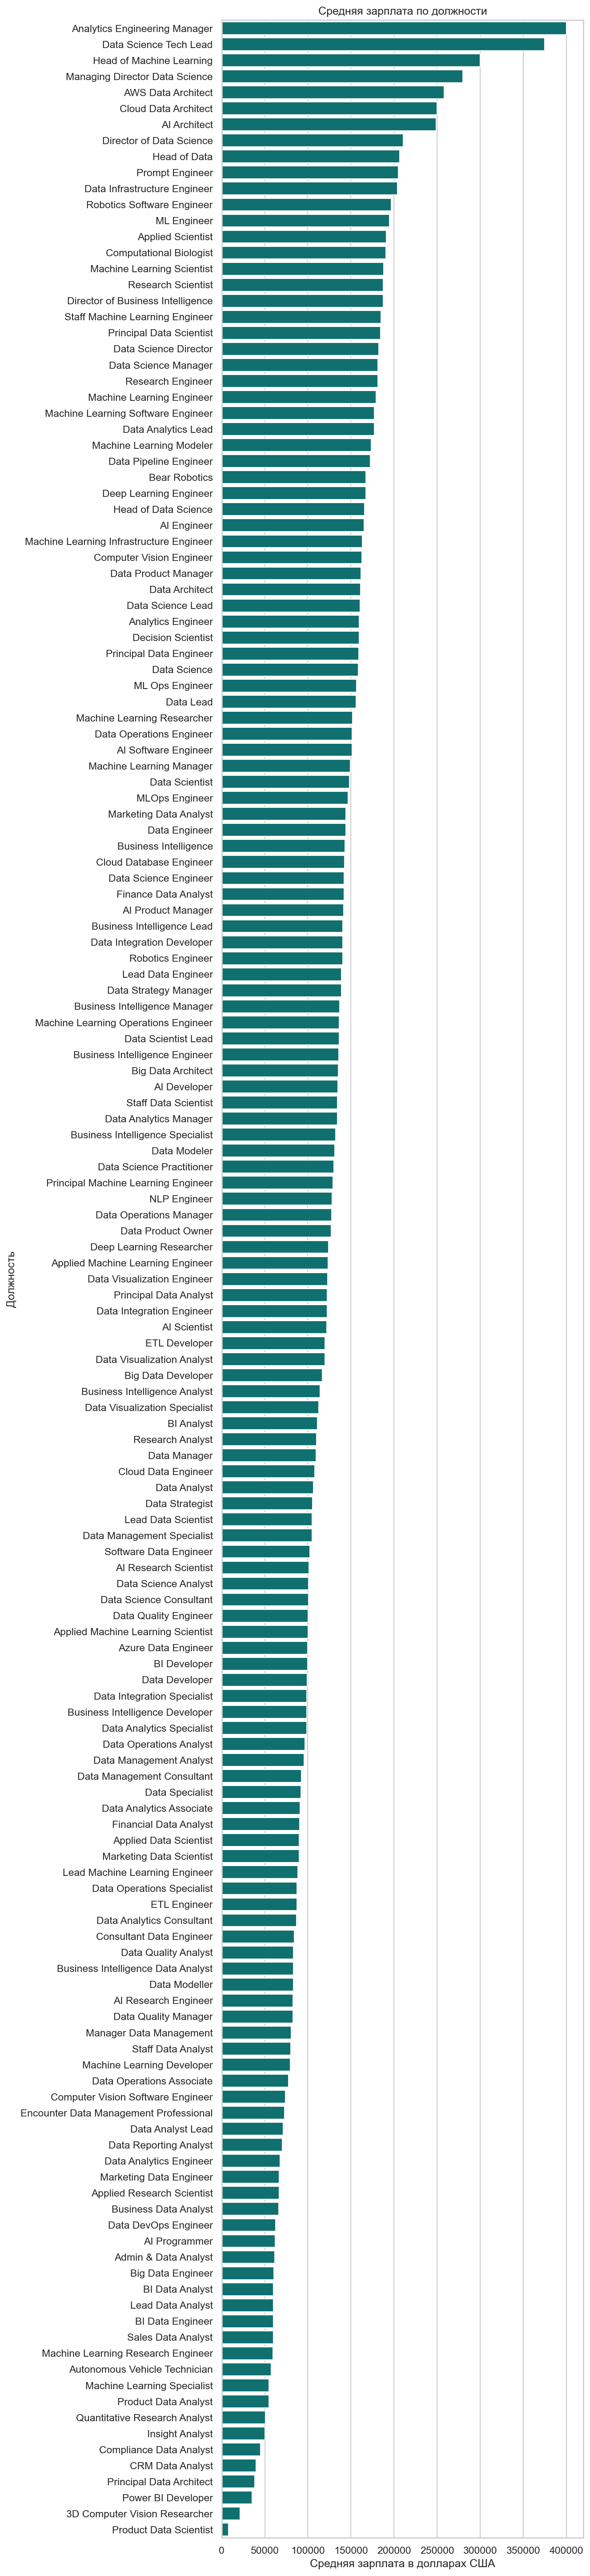

In [14]:
plt.figure(figsize=(7, 49), dpi=150)
job_salary = df.groupby('job_title')["salary_in_usd"].mean().sort_values(ascending=False).round()

sns.barplot(y=job_salary.index, x=job_salary.values, color="teal")
plt.title("Средняя зарплата по должности")
plt.xlabel("Средняя зарплата в долларах США")
plt.ylabel("Должность")
plt.show()

## Изменение заработной платы по годам (Bar Plot)

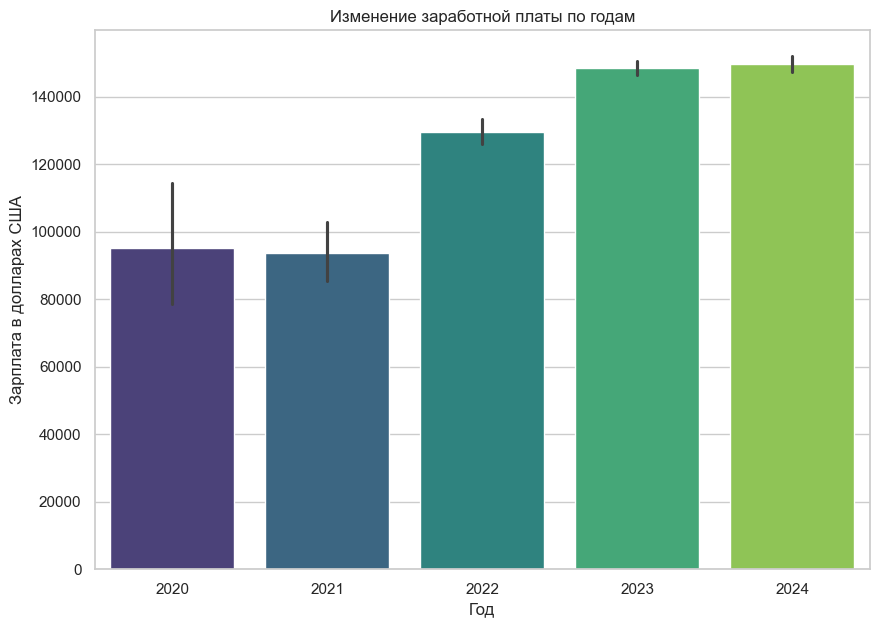

In [15]:
plt.figure(figsize=(10, 7))
sns.barplot(df, x="work_year", y="salary_in_usd", palette="viridis")
plt.title("Изменение заработной платы по годам")
plt.xlabel("Год")
plt.ylabel("Зарплата в долларах США")
plt.show()

## Изменение заработной платы по годам в зависимости от уровня опыта

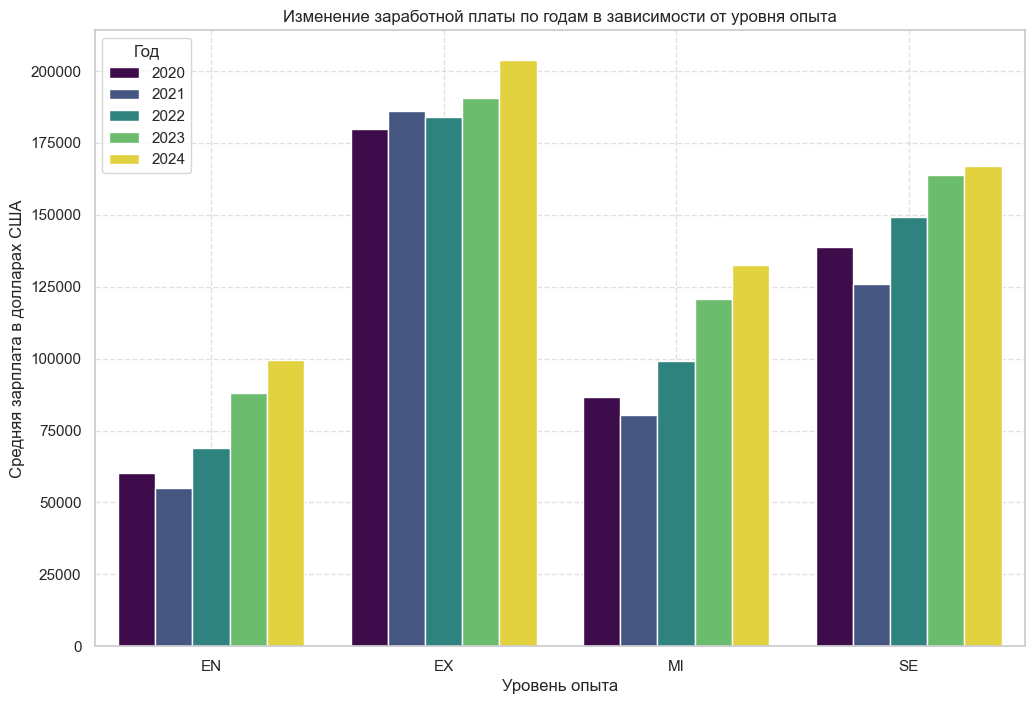

In [16]:
exp_salary = df.groupby(['experience_level', 'work_year'])['salary_in_usd'].mean().round().reset_index()

plt.figure(figsize=(12, 8))
sns.barplot(data=exp_salary, hue="work_year", y="salary_in_usd", x="experience_level", palette="viridis")

plt.title("Изменение заработной платы по годам в зависимости от уровня опыта")
plt.xlabel("Уровень опыта")
plt.ylabel("Средняя зарплата в долларах США")
plt.legend(title="Год")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


## Тепловая карта корреляции для числовых признаков

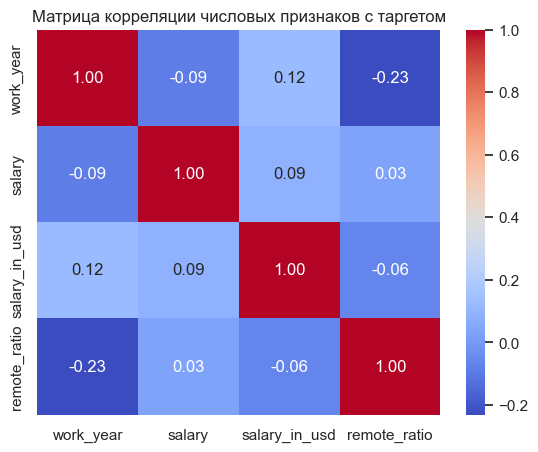

In [18]:
numeric_cols = df.select_dtypes("number").columns.tolist()
cor_matrix = df[numeric_cols].corr()
plt.figure(figsize=(6.5, 5), dpi=100)
sns.heatmap(cor_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Матрица корреляции числовых признаков с таргетом");

### 5. Создание признаков и предобработка данных 🛠️🐉  
Наши данные полны скрытых историй, но модель понимает только язык чисел. Пора перевести эти загадки в понятный ей формат!

- **Выбор ключевых признаков:** Мы отберём те колонки, которые, скорее всего, приведут нас к зарплатному кладу! 💰🏴‍☠️  
- **One-Hot Encoding:** Превратим категориальные переменные в цифровую магию. 📊✨  
- **Разделение на обучающую и тестовую выборку:** Готовим почву для грандиозной битвы модели с данными! ⚔️🤖  

**Ведь каждый герой нуждается в правильной экипировке, прежде чем сразиться с драконом! 🐉🔥**

In [19]:
features = df.drop(columns=["salary", "salary_in_usd"]).columns.tolist()
target = "salary_in_usd"

X = df[features].copy()
y = df[target].copy()

cat_cols = X.select_dtypes("object").columns.tolist()
num_cols = X.select_dtypes("number").columns.tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [20]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', TargetEncoder(), cat_cols)
    ])

# Модель 1: Линейная регрессия

In [21]:
# Модель Linear Regression
model_lr = LinearRegression()

# Параметры для RandomizedSearchCV
param_grid_lr = {
    'model__fit_intercept': [True, False]
}

# Пайплайн для Linear Regression
pipeline_lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model_lr)
])

# RandomizedSearchCV для Linear Regression
search_lr = RandomizedSearchCV(
    pipeline_lr,
    param_distributions=param_grid_lr,
    n_iter=2,
    cv=5,
    scoring='neg_mean_absolute_percentage_error',
    random_state=42,
    n_jobs=-1
)
search_lr.fit(X_train, y_train)
best_pipeline_lr = search_lr.best_estimator_
print("Лучшие параметры для Linear Regression:", search_lr.best_params_)

Лучшие параметры для Linear Regression: {'model__fit_intercept': True}


# Модель 2: Случайный лес

In [22]:
# Модель Random Forest
model_rf = RandomForestRegressor()

# Параметры для RandomizedSearchCV
param_grid_rf = {
    'model__n_estimators': [50, 100, 200],
    'model__max_depth': [5, 10, 15, None],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}

# Пайплайн для Random Forest
pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model_rf)
])

# RandomizedSearchCV для Random Forest
search_rf = RandomizedSearchCV(
    pipeline_rf,
    param_distributions=param_grid_rf,
    n_iter=10,
    cv=5,
    scoring='neg_mean_absolute_percentage_error',
    random_state=42,
    n_jobs=-1
)
search_rf.fit(X_train, y_train)
best_pipeline_rf = search_rf.best_estimator_
print("Лучшие параметры для Random Forest:", search_rf.best_params_)

Лучшие параметры для Random Forest: {'model__n_estimators': 50, 'model__min_samples_split': 2, 'model__min_samples_leaf': 4, 'model__max_depth': 10}


# Модель 3: CatBoost

In [23]:
# Модель CatBoost
model_cb = CatBoostRegressor(verbose=0)

# Параметры для RandomizedSearchCV
param_grid_cb = {
    'model__iterations': [100, 300, 500],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__depth': [4, 6, 8, 10]
}

# Пайплайн для CatBoost
pipeline_cb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model_cb)
])

# RandomizedSearchCV для CatBoost
search_cb = RandomizedSearchCV(
    pipeline_cb,
    param_distributions=param_grid_cb,
    n_iter=10,
    cv=5,
    scoring='neg_mean_absolute_percentage_error',
    random_state=42,
    n_jobs=-1
)
search_cb.fit(X_train, y_train)
best_pipeline_cb = search_cb.best_estimator_
print("Лучшие параметры для CatBoost:", search_cb.best_params_)

Лучшие параметры для CatBoost: {'model__learning_rate': 0.1, 'model__iterations': 500, 'model__depth': 6}


# Оценка качество моделей

In [24]:
# Модели
models = {
    "Linear Regression": best_pipeline_lr,
    "Random Forest": best_pipeline_rf,
    "CatBoost": best_pipeline_cb
}

# Сетки гиперпараметров
param_grids = {
    "Linear Regression": param_grid_lr,
    "Random Forest": param_grid_rf,
    "CatBoost": param_grid_cb
}

# Определение лучшей модели по тестовой выборке

In [29]:
# Словарь для хранения предсказаний и результатов кросс-валидации
predictions = {
    "Model": [],
    "y_pred_train": [],
    "y_pred_test": [],
    "CV R² Scores": []
}

# Сбор предсказаний и кросс-валидация
for name, model in models.items():
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
    
    predictions["Model"].append(name)
    predictions["y_pred_train"].append(y_pred_train)
    predictions["y_pred_test"].append(y_pred_test)
    predictions["CV R² Scores"].append(cv_scores)

# Преобразование в DataFrame
predictions_df = pd.DataFrame(predictions)
print("\nПредсказания собраны:")


Предсказания собраны:


In [30]:
# Словарь для хранения метрик
results = {
    "Model": [],
    "MAPE Train (%)": [],
    "MAPE Test (%)": [],
    "R² Train (%)": [],
    "R² Test (%)": [],
    "CV R² Mean (%)": []
}

# Расчет метрик
for index, row in predictions_df.iterrows():
    model_name = row["Model"]
    y_pred_train = row["y_pred_train"]
    y_pred_test = row["y_pred_test"]
    cv_scores = row["CV R² Scores"]
    
    # Метрики на тренировочной выборке
    mape_train = mean_absolute_percentage_error(y_train, y_pred_train)
    r2_train = r2_score(y_train, y_pred_train)
    
    # Метрики на тестовой выборке
    mape_test = mean_absolute_percentage_error(y_test, y_pred_test)
    r2_test = r2_score(y_test, y_pred_test)
    
    # Среднее значение R² по кросс-валидации
    cv_r2_mean = cv_scores.mean()
    
    # Добавление результатов
    results["Model"].append(model_name)
    results["MAPE Train (%)"].append(100 * mape_train)
    results["MAPE Test (%)"].append(100 * mape_test)
    results["R² Train (%)"].append(100 * r2_train)
    results["R² Test (%)"].append(100 * r2_test)
    results["CV R² Mean (%)"].append(100 * cv_r2_mean)

# Преобразование в DataFrame
results_df = pd.DataFrame(results)

In [31]:
# Вывод результатов
print("Сравнение моделей по различным метрикам:")
display(results_df.round(2))

# Лучшая модель по MAPE
best_model_mape = results_df.loc[results_df["MAPE Test (%)"].idxmin()]
print(f"\nЛучшая модель по MAPE на тестовой выборке: {best_model_mape['Model']} "
      f"с MAPE = {best_model_mape['MAPE Test (%)']:.2f}%")

# Лучшая модель по R²
best_model_r2 = results_df.loc[results_df["R² Test (%)"].idxmax()]
print(f"Лучшая модель по R² на тестовой выборке: {best_model_r2['Model']} "
      f"с R² = {best_model_r2['R² Test (%)']:.2f}%")

Сравнение моделей по различным метрикам:


,Model,MAPE Train (%),MAPE Test (%),R² Train (%),R² Test (%),CV R² Mean (%)
0,Linear Regression,38.69,40.25,32.97,32.39,31.32
1,Random Forest,32.48,35.88,40.70,35.31,31.96
2,CatBoost,30.70,35.57,43.82,35.55,32.00



Лучшая модель по MAPE на тестовой выборке: CatBoost с MAPE = 35.57%
Лучшая модель по R² на тестовой выборке: CatBoost с R² = 35.55%
